### The goal of this kernel is to create a simple Convolution Neural Network that will allow to differentiate images that contains cacti from images that do not. While better results closer to 100% accuracy could be designed using layers from pre-trained models such as VGG16, we want to stick with a fairly simple CNN architecture and see how far we can go, and whether pre-trained layers are even needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import os
from shutil import copyfile, move
from tqdm import tqdm
import h5py

Just a quick check to make verify Tensorflow version and whether the GPU is found.

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())

1.13.1
True


# Prepare the data

In order to prepare the dataset and use Keras' ImageDataGenerator, it was decided to extract the images to a new folder where images are sorted into 2 folders, one for images with cacti, and one for images without. It is, therefore, required to load the .csv file provided to retrieve the groundtruth and copy the files in the right folder.

In [3]:
training_df = pd.read_csv("../input/train.csv")
training_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
src = "../input/train/train/"
dst = "../sorted_training/"

os.mkdir(dst)
os.mkdir(dst+"true")
os.mkdir(dst+"false")

with tqdm(total=len(list(training_df.iterrows()))) as pbar:
    for idx, row in training_df.iterrows():
        pbar.update(1)
        if row["has_cactus"] == 1:
            copyfile(src+row["id"], dst+"true/"+row["id"])
        else:
            copyfile(src+row["id"], dst+"false/"+row["id"])

100%|██████████| 17500/17500 [00:16<00:00, 1082.21it/s]


I then extract the validation from the folder where I stored the training set. Note that this time, the files are moved and not just copied.

In [5]:
src = "../sorted_training/"
dst = "../sorted_validation/"

os.mkdir(dst)
os.mkdir(dst+"true")
os.mkdir(dst+"false")

validation_df = training_df.sample(n=int(len(training_df)/10))

with tqdm(total=len(list(validation_df.iterrows()))) as pbar:
    for idx, row in validation_df.iterrows():
        pbar.update(1)
        if row["has_cactus"] == 1:
            move(src+"true/"+row["id"], dst+"true/"+row["id"])
        else:
            move(src+"false/"+row["id"], dst+"false/"+row["id"])

100%|██████████| 1750/1750 [00:00<00:00, 8077.41it/s]


# Load the dataset

Even though it is considered good practice to import all libraries at the beginning of a script, I tend to import the ones related to the model architecture right before, as it makes them visible and gives expectations to a reader as to what to find in the architecture.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

The dataset being relatively small, data augmentation is very important to generalise and learn what a cactus look like. Based on the fact that cactus detection seems like an easy problem and we're dealing with a small amount of data, the batch size is kept small as training will be quick anyway.

In [7]:
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True)

train_data_dir = "../sorted_training"
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    shuffle=True,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary')


validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_data_dir = "../sorted_validation"
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(32, 32),
    batch_size=batch_size,
    class_mode='binary')

input_shape = (32,32,3)
num_classes = 2


Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


# Model Creation: Convolutional Neural Network

Some really insightful comments about deep learning model optimization can be found here (https://karpathy.github.io/2019/04/25/recipe/ ). 

In [8]:
dropout_dense_layer = 0.6

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(dropout_dense_layer))

model.add(Dense(1))
model.add(Activation('sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

In [10]:
callbacks = [EarlyStopping(monitor='val_loss', patience=25),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

# Training

In [11]:
epochs = 100
history = model.fit_generator(train_generator,
          validation_data=validation_generator,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
247/247 [==============================] - 16s 66ms/step - loss: 0.1323 - acc: 0.9495 - val_loss: 2.6215 - val_acc: 0.2669
Epoch 2/100
247/247 [==============================] - 12s 48ms/step - loss: 0.0680 - acc: 0.9756 - val_loss: 0.0751 - val_acc: 0.9697
Epoch 3/100
247/247 [==============================] - 12s 49ms/step - loss: 0.0613 - acc: 0.9784 - val_loss: 0.1612 - val_acc: 0.9520
Epoch 4/100
247/247 [==============================] - 13s 52ms/step - loss: 0.0433 - acc: 0.9859 - val_loss: 0.0515 - val_acc: 0.9863
Epoch 5/100
247/247 [==============================] - 12s 48ms/step - loss: 0.0388 - acc: 0.9877 - val_loss: 0.0456 - val_acc: 0.9869
Epoch 6/100
247/247 [==============================] - 12s 48ms/step - loss: 0.0334 - acc: 0.9898 - val_loss: 0.0351 - val_acc: 0.9909
Epoch 7/100
247/247 [==============================] - 12s 47ms/step - loss: 0.0324 - acc: 0.9897 - val_loss: 0.1096 - val_acc: 0.9640
Epoch 8

Display the losses and accuracy of the model over the training and validation sets.

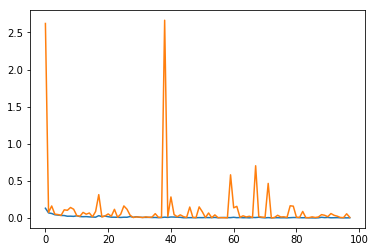

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

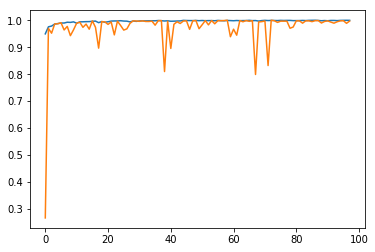

In [13]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

# Load the test data and evaluate the model

Load the best performing model based on the validation loss.

In [14]:
model.load_weights("best_model.h5")

In [15]:
test_folder = "../input/test/"
test_datagen = ImageDataGenerator(
    rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_folder,
    target_size=(32,32),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 4000 images belonging to 1 classes.


In [16]:
pred=model.predict_generator(test_generator,verbose=1)
pred_binary = [0 if value<0.50 else 1 for value in pred]  

4000/4000 [==============================] - 38s 9ms/step


Generate the submission .csv file.

In [17]:
csv_file = open("sample_submission_cnn.csv","w")
csv_file.write("id,has_cactus\n")
for filename, prediction in zip(test_generator.filenames,pred_binary):
    name = filename.split("/")[1].replace(".tif","")
    csv_file.write(str(name)+","+str(prediction)+"\n")
csv_file.close()